In [5]:
import re
from pprint import pprint
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
#from category_encoders import TargetEncoder, CatBoostEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics

import xgboost as xgb
import lightgbm as lgb

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

In [6]:
method = "target"
assert method in ["label", "target", "onehot", "catboost"]

features = pd.read_csv(f"../data/processed/{method}/train.csv")
test = pd.read_csv(f"../data/processed/{method}/test.csv")

targets = features["label"].values

features.drop(["label"], inplace=True, axis=1)

print(features.shape, test.shape)

(80176, 20) (34365, 20)


### Gridsearch with HypeOPT

In [7]:
def objective(space):
    classifier = lgb.LGBMClassifier(num_leaves=int(space["num_leaves"]),
                                   n_estimators=int(space['n_estimators']),
                                   max_depth=int(space['max_depth']),
                                   learning_rate = space['learning_rate'],
                                   min_child_weight = space['min_child_weight'],
                                   subsample = space['subsample'],
                                   colsample_bytree = space['colsample_bytree'],
                                   objective="multiclass"
                                )
    #classifier.fit(features, targets)    
    scores = cross_val_score(estimator=classifier,
                             n_jobs=5,
                             X=features, 
                             y=targets, 
                             cv=StratifiedKFold(n_splits=5),
                             scoring="f1_micro"
                            )
    mean_score = scores.mean()
    
    return {
        'loss': 1 - mean_score, 
        'status': STATUS_OK 
    }

In [89]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 5),
    'max_depth' : hp.quniform('max_depth', 3, 30, 2),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.3, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 20, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01),
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
}

trials = Trials()
best = fmin(fn=objective, 
            verbose=5,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

100%|██████████| 50/50 [05:27<00:00,  6.55s/trial, best loss: 0.3982363753895487]


In [90]:
best

{'colsample_bytree': 0.75,
 'learning_rate': 0.05,
 'max_depth': 30.0,
 'min_child_weight': 10.0,
 'n_estimators': 75.0,
 'num_leaves': 20.0,
 'subsample': 0.66}

In [91]:
best["max_depth"] = int(best["max_depth"])
best["n_estimators"] = int(best["n_estimators"])
best["num_leaves"] = int(best["num_leaves"])

### Testing cross_val_score: 

In [92]:
model = lgb.LGBMClassifier(**best)
scores = cross_val_score(model, features, targets, scoring="f1_micro", verbose=2, n_jobs=5)
print(f"mean score: {np.mean(scores)}")

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.2s remaining:    4.8s


mean score: 0.6017636246104513


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.8s finished


### Train best model on all data

In [93]:
model = lgb.LGBMClassifier(**best)
model.fit(features, targets)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.75,
               importance_type='split', learning_rate=0.05, max_depth=30,
               min_child_samples=20, min_child_weight=10.0, min_split_gain=0.0,
               n_estimators=75, n_jobs=-1, num_leaves=20, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.66, subsample_for_bin=200000, subsample_freq=0)

In [94]:
feature_importance = pd.DataFrame()
feature_importance["imp"] = model.feature_importances_
feature_importance["feature"] = model.feature_name_

In [95]:
feature_importance.set_index("feature", inplace=True)

<AxesSubplot:ylabel='feature'>

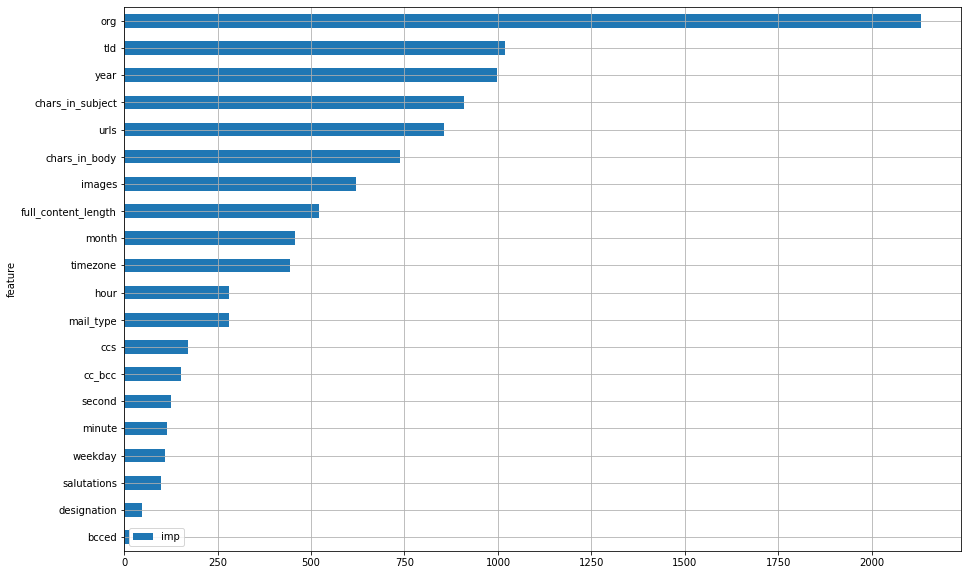

In [96]:
feature_importance.sort_values(by="imp", ascending=True).plot(kind="barh", figsize=(15, 10), grid=True)

### Submission 

In [97]:
submission = pd.DataFrame()
submission["Id"] = range(len(test))
submission["label"] = model.predict(test)
submission.to_csv(f"../data/submissions/lgbm_{method}.csv", index=False)

### Save proba

In [98]:
probas = pd.DataFrame()
probas["Id"] = range(len(test))

probas = pd.concat([probas, pd.DataFrame(model.predict_proba(test))], axis=1)

In [99]:
probas.to_csv(f"../data/submissions/lgbm_probas_{method}.csv", index=False)

# 0.60529 public leaderboard